# J-Quants API Quick Start Guide

In [ ]:
#@title Initial Setting and Import packages
#@markdown Press the ▶ button on the left, and run the code in Google Colab.

#@markdown First, run this code to import the packages required to use the J-Quants API.

import json
import sys
import requests

from IPython.display import display
import pandas as pd

pd.set_option("display.max_columns", None)

API_URL = "https://api.jquants.com"

## Step1：Procedure to start using J-Quants API (*only for the first time)

**To use J-Quants API, you will need to do the following two things in advance**
 1. Register [J-Quants web site](https://jpx-jquants.com/?lang=en)
 2. Select a plan（Free, Light, Standard, Premium）

If you have not yet registered or selected a plan, please complete the above two items first.  
Click [here](https://jpx.gitbook.io/j-quants-en/outline/getstarted) for more specific instructions.

##Step2 and Step3：Get refresh token and idToken
There are two ways to get a refresh token.
1. Log in to J-Quants web site, click "Get Refresh Token" button.
2. Use the Refresh Token API

Please get a refresh token and idToken using either of the methods listed below.

In [ ]:
#@title **1. Log in to J-Quants web site, click "Get Refresh Token" button.**
#@markdown Paste the refresh token obtained from the J-Quants web site into the "insert text here" section below.

refreshtoken = ""#@param {type: "string"}

res = requests.post(f"{API_URL}/v1/token/auth_refresh?refreshtoken={refreshtoken}")
if res.status_code == 200:
    id_token = res.json()['idToken']
    headers = {'Authorization': 'Bearer {}'.format(id_token)}
    display("You got an idToken")
else:
    display(res.json()["message"])


#@markdown If you see a message "You got an idToken", you have prepared for using J-Quants API.

###**2. Use the Refresh Token API**

In [ ]:
#@title Mount Google Drive

#@markdown It may not be appropriate for security reasons to write directly your ID or password in this notebook,

#@markdown therefore we recommend creating a setting file in Google Drive and write them in it.

#@markdown First of all, execute this code, and mount your google drive.


from google.colab import drive

try:
    drive.mount('/content/drive')
except:
    print("Failed to mount Google Drive.")
else:
    print("Succeeded to mount Google Drive.")

#### Create a setting file (only for the first time)
- Create a setting file like following image. (e.g. drive→MyDrive→drive_ws→secret→jquants-api.toml)

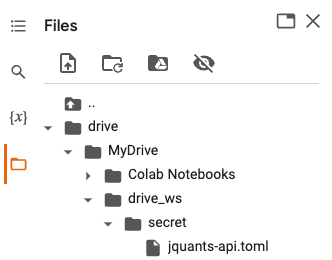

- Write your ID and password in the file you created like following sample.<br>
(Note that you need to replace * to your ID and password.)

```
[jquants-api-client]
mailaddress = "*****@***.***"
password = "**************"
```

In [ ]:
#@title Load the created file, get a refresh token and an idToken.
#@markdown If you create the setting file properly, you can get an idToken executing this code.

#@markdown When you see a message "Preparation is Completed", you can use J-Quants API!!

if sys.version_info >= (3, 11):
    import tomllib
else:
    import tomli as tomllib

config_path = ("/content/drive/MyDrive/drive_ws/secret/jquants-api.toml")

with open(config_path, mode="rb") as f:
    ret = tomllib.load(f)["jquants-api-client"]

USER_DATA = {k: v for k, v in ret.items()}

# refresh token取得
try:
  res = requests.post(f"{API_URL}/v1/token/auth_user", data=json.dumps(USER_DATA))
  refresh_token = res.json()['refreshToken']
except:
  print("Failed to get a RefreshToken")
else:
  # id token取得
  try:
    res = requests.post(f"{API_URL}/v1/token/auth_refresh?refreshtoken={refresh_token}")
    id_token = res.json()['idToken']
  except:
    print("Failed to get an idToken")
  else:
    headers = {'Authorization': 'Bearer {}'.format(id_token)}
    print("Preparation is completed")

## Step4： Let's enjoy J-Quants API.

### Free plan
- Listed Issue Information （/listed/info）
- Stock Prices(OHLC)* （/prices/daily_quotes）
- Financial Data （/fins/statements)
- Earnings Calendar （/fins/announcement）
- Trading Calendar（/markets/trading_calendar）

\*  Historical data of morning and afternoon session's prices is available to only premium plan user.


In [ ]:
#@title Listed Issue Information（/listed/info）

#@markdown - listed issue Information as of the past, the current day, and the next business day can be retrieved.
#@markdown - When acquiring data, issue code (code) or date (date) **can** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 24:00


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date

res = requests.get(f"{API_URL}/v1/listed/info", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["info"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/listed/info", params=params, headers=headers)
    d = res.json()
    data += d["info"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Stock Prices(OHLC)（/prices/daily_quotes）

#@markdown - Stock price consists before and after adjustment of stock splits and reverse stock splits (Rounded to first decimal places)
#@markdown - In your request message, either "code" or "date" **must** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 17:00


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/prices/daily_quotes", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["daily_quotes"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/prices/daily_quotes", params=params, headers=headers)
    d = res.json()
    data += d["daily_quotes"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Financial Data（/fins/statements）

#@markdown - Obtain quarterly earnings summaries and disclosure information (mainly numerical data) on revisions to earnings and dividend information for listed companies.
#@markdown - In your request message, either "code" or "date" **must** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 18:00(preliminary) and around 24:30(final)


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date

res = requests.get(f"{API_URL}/v1/fins/statements", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["statements"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/fins/statements", params=params, headers=headers)
    d = res.json()
    data += d["statements"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Earnings Calendar（/fins/announcement）

#@markdown （Update timing）
#@markdown - Irregularly around 19:00

#@markdown - It will be updated only when there is an update for companies which end their fiscal year in March or September at [this site](https://www.jpx.co.jp/listing/event-schedules/financial-announcement/index.html).

params = {}

res = requests.get(f"{API_URL}/v1/fins/announcement", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["announcement"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/fins/announcement", params=params, headers=headers)
    d = res.json()
    data += d["announcement"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Trading Calendar（/market/trading_calendar）

#@markdown - You can obtain information on market business days, holidays in TSE/OSE market, and the availability of holiday trading in OSE market.
#@markdown - In your request message, either "holiday division" or "from/to" can be specified.

#@markdown （Update timing）
#@markdown - Irregular（The business days and holiday trading dates (tentative) for the following year will be updated around February of each year.）


holidaydivision = ""#@param ["0", "1", "2", "3"]{allow-input:true}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if holidaydivision != "":
  params["holidaydivision"] = holidaydivision
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/markets/trading_calendar", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["trading_calendar"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/trading_calendar", params=params, headers=headers)
    d = res.json()
    data += d["trading_calendar"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

### Light plan
- Trading by Type of Investors（/markets/trades_spec）
- TOPIX Prices(OHLC)（/indices/topix）

In [ ]:
#@title 投資部門別（株式）データ（/markets/trades_spec）

#@markdown - Trading by type of investors (stock trading value) can be obtained.
#@markdown - In your request message, either "section" or "from/to" can be specified.

#@markdown （Update timing）
#@markdown - Weekly(4th business day)、around 18:00


section = ""#@param ["TSE1st", "TSE2nd", "TSEMothers", "TSEJASDAQ", "TSEPrime", "TSEStandard", "TSEGrowth", "TokyoNagoya"] {allow-input: true}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if section != "":
  params["section"] = section
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/markets/trades_spec", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["trades_spec"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/trades_spec", params=params, headers=headers)
    d = res.json()
    data += d["trades_spec"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())


In [ ]:
#@title TOPIX Prices(OHLC)（/indices/topix）

#@markdown - Available index is TOPIX（Tokyo Stock Price Index）.
#@markdown - In your request message, "from/to" can be specified.

#@markdown （Update timing）
#@markdown - Daily, around 16:30


date_from = ""#@param {type:"string"}
date_to = ""#@param {type:"string"}

params = {}

if date_from != "":
  params["from"] = date_from
if date_to != "":
  params["to"] = date_to

res = requests.get(f"{API_URL}/v1/indices/topix", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["topix"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/indices/topix", params=params, headers=headers)
    d = res.json()
    data += d["topix"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())


### Standard plan
- Indices（/Indices）
- Index Option Prices(OHLC)（/option/index_option）
- Margnin Trading Outstandings（/markets/weekly_margin_interest）
- Short Sale value and Ratio by Sector（/markets/short_selling）
- Outstanding Short Selling Positions Reported (/markets/short_selling_positions)

In [ ]:
#@title Indices（/indices）

#@markdown - Available various indices OHLC.
#@markdown - In your request message, either "code" or "date" **must** be specified.

#@markdown （Update Timing）
#@markdown - Daily, around 16:30


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/indices", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["indices"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/indices", params=params, headers=headers)
    d = res.json()
    data += d["indices"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Index Option Prices(OHLC)（/option/index_option）

#@markdown - Information on the OHLC, settlement price, and theoretical price of Nikkei 225 Options can be obtained through this API.
#@markdown - When acquiring data, "date" **must** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 27:00


date = "" #@param {type:"string"}
params = {}
if date != "":
  params["date"] = date

res = requests.get(f"{API_URL}/v1/option/index_option", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["index_option"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/option/index_option", params=params, headers=headers)
    d = res.json()
    data += d["index_option"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Margin Trading Outstandings（/markets/weekly_margin_interest）

#@markdown - Weekly margin trading outstandings as of the last business day of each week is available.
#@markdown - This data is also available via [this page](https://www.jpx.co.jp/english/markets/statistics-equities/margin/index.html).
#@markdown - In your request message, either "code" or "date" **must** be specified.

#@markdown （Update timing）
#@markdown - Weekly(2nd business day) around 16:30

code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/markets/weekly_margin_interest", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["weekly_margin_interest"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/weekly_margin_interest", params=params, headers=headers)
    d = res.json()
    data += d["weekly_margin_interest"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Short Sale Value and Ratio by Sector（/markets/short_selling）

#@markdown - You can obtain daily trading values related to short sale ratios by industry (sector).
#@markdown - This data is also available via [this page](https://www.jpx.co.jp/english/markets/statistics-equities/short-selling/index.html).
#@markdown - When acquiring data, "date" or "sector33code" **must** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 17:00

#@markdown （Note）
#@markdown - Industry code 9999 is for stocks that are not included in the 33 industry categories, such as ETFs and REITs.


sector33code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if sector33code != "":
  params["sector33code"] = sector33code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/markets/short_selling", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["short_selling"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/short_selling", params=params, headers=headers)
    d = res.json()
    data += d["short_selling"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Outstanding Short Selling Positions Reported (/markets/short_selling_positions)

#@markdown - This data covers the outstanding short selling position ratio is 0.5% or more of those reported by trading participants in accordance with the "Cabinet Office Order on Restrictions on Securities Transactions".
#@markdown - In your request message, either issue code (code) or disclosed date (disclosed_date) or calculated date (calculated_date) **must** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 17:30

code = ""#@param {type:"string"}
disclosed_date = ""#@param {type:"string"}
disclosed_date_from = ""#@param {type:"string"}
disclosed_date_to = ""#@param {type:"string"}
calculated_date = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if disclosed_date != "":
  params["disclosed_date"] = disclosed_date
if disclosed_date_from != "":
  params["disclosed_date_from"] = disclosed_date_from
if disclosed_date_to != "":
  params["disclosed_date_to"] = disclosed_date_to
if calculated_date != "":
  params["calculated_date"] = calculated_date

res = requests.get(f"{API_URL}/v1/markets/short_selling_positions", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["short_selling_positions"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/short_selling_positions", params=params, headers=headers)
    d = res.json()
    data += d["short_selling_positions"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

### Premium plan
- Breakdown Trading Data（/markets/breakdown）
- Morning Session Stock Prices(OHLC)（/prices/AM）
- Cash Dividend Data（/fins/dividend）
- Financial Statement Data(BS/PL) (/fins/fs_details)
- Futures(OHLC)(/derivatives/futures)
- Options(OHLC)(/derivatives/options)

In [ ]:
#@title Breakdown Trading Data（/markets/breakdown）

#@markdown - Detail Breakdown Trading Data is extracted from daily trading values and volumes (only regular trading sessions on the TSE market) per TSE-listed issue based on flags for margin transactions and short selling that are attached to orders at the time of placement.
#@markdown - In your request message, either "code" or "date" **must** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 18:00


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/markets/breakdown", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["breakdown"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/breakdown", params=params, headers=headers)
    d = res.json()
    data += d["breakdown"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Morning Session Stock Prices(OHLC)（/prices/AM）

#@markdown - You can obtain the morning session's high, low, opening, and closing prices for individual stocks as quick updates at noon.
#@markdown - In your request message, either "code" **can** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 12:00


code = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code

res = requests.get(f"{API_URL}/v1/prices/prices_am", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["prices_am"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/prices/prices_am", params=params, headers=headers)
    d = res.json()
    data += d["prices_am"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Cash Dividend Data（/fins/dividend）

#@markdown - Provides information on dividends (determined and forecast) per share of listed companies, record date, ex-rights date, and payable date.
#@markdown - When acquiring data, issue code (code) or date (date) **can** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 18:00


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/fins/dividend", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["dividend"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/fins/dividend", params=params, headers=headers)
    d = res.json()
    data += d["dividend"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Financial Statement Data(BS/PL) (/fins/fs_details)

#@markdown - You can obtain the entries in the balance sheet and income statement of a listed companies in their quarterly financial information.
#@markdown - In this code, you can switch how the output results are displayed by specifying the format_type: flat: all items are displayed in the header; non-flat: detailed items are consolidated in one column.
#@markdown - In your request message, either issue code (code) or disclosure date (date) **must** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 18:00(preliminary) and around 24:30(final)


format_type = "non-flat"#@param ["non-flat", "flat"]
code = ""#@param {type:"string"}
date = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date

res = requests.get(f"{API_URL}/v1/fins/fs_details", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["fs_details"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/fins/fs_details", params=params, headers=headers)
    d = res.json()
    data += d["daily_quotes"]
  if format_type == "non-flat":
    df = pd.DataFrame(data)
  else:
    df = pd.json_normalize(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Futures(OHLC)(/derivatives/futures)

#@markdown - Information on the OHLC, settlement price, and theoretical price of futures can be obtained through this API. 
#@markdown - In your request message, date (date) **must** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 27:00

category = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = ""#@param{type:"string"}
to_ = ""#@param{type:"string"}
contract_flag = ""#@param{type:"string"}

params = {}
if category != "":
  params["category"] = category
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to
if contract_flag != "":
  params["contract_flag"] = contract_flag

res = requests.get(f"{API_URL}/v1/derivatives/futures", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["futures"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/derivatives/futures", params=params, headers=headers)
    d = res.json()
    data += d["futures"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title Options(OHLC)(/derivatives/options)

#@markdown - Information on the OHLC, settlement price, and theoretical price of options can be obtained through this API.
#@markdown - In your request message, date (date) **must** be specified.

#@markdown （Update timing）
#@markdown - Daily, around 27:00

category = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = ""#@param{type:"string"}
to_ = ""#@param{type:"string"}
contract_flag = ""#@param{type:"string"}

params = {}
if category != "":
  params["category"] = category
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to
if contract_flag != "":
  params["contract_flag"] = contract_flag

res = requests.get(f"{API_URL}/v1/derivatives/options", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["options"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/derivatives/options", params=params, headers=headers)
    d = res.json()
    data += d["options"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())